# Cell type deconvolution using MacSGP

In [1]:
import pandas as pd
import numpy as np
import scanpy as sc
import anndata as ad
import os

import warnings
warnings.filterwarnings("ignore")

os.environ["CUDA_VISIBLE_DEVICES"] = "0"

import sys
sys.path.append(r'/import/home2/share/yqzeng/MacSGP/codes')
import MacSGP

In [2]:
RAW_PATH = "/import/home2/share/yqzeng/data/kidney_cancer/Mapping single cell transcriptomes in kidney cancer" # Raw data
DATA_PATH = "/import/home2/share/yqzeng/MacSGP/data/kidney_cancer" # Deconvolution results
os.makedirs(os.path.join(DATA_PATH), exist_ok = True)

In [3]:
donor_id = "PD47171"

In [4]:
# scRNA-seq reference data
adata_ref = ad.read_h5ad(os.path.join(RAW_PATH, 'RCC_upload_final_raw_counts.h5ad'))
adata_ref = adata_ref[adata_ref.obs["patient"] == donor_id]

In [5]:
# ST data
adata_st = ad.read_h5ad(os.path.join(RAW_PATH, "visium_merge_inter_upload.h5ad"))
adata_st = adata_st[adata_st.obs["donor_id"] == donor_id]
adata_st.uns["spatial"] = {'spaceranger130_count_44214_6800STDY12499411_GRCh38-2020-A': adata_st.uns["spatial"]['spaceranger130_count_44214_6800STDY12499411_GRCh38-2020-A']}
adata_st.var_names = list(adata_st.var['SYMBOL'])
adata_st.var_names_make_unique()

In [6]:
MacSGP.utils.Cal_Spatial_Net(adata_st, mode='KNN', k_cutoff=6)

Calculating spatial neighbor graph ...
The graph contains 13036 edges, 2048 spots.
6.365234375 neighbors per spot on average.


In [7]:
adata_st, adata_basis = MacSGP.utils.preprocess(adata_st,adata_ref,
                                                celltype_ref_col = "broad_type",
                                                n_hvg_group = 500)

Finding highly variable genes...
3988 highly variable genes selected.
Calculate basis for deconvolution...
Preprocess ST data...


In [8]:
model = MacSGP.model.Model_deconv(adata_st, adata_basis, n_layers =4, training_steps=10000)
model.train(step_interval=1000, use_amp=False)
adata_st = model.eval()

  0%|          | 14/10000 [00:00<08:10, 20.35it/s] 

Step: 0, Loss: -4086.4998, d_loss: -4092.3206, f_loss: 58.2077


 10%|█         | 1018/10000 [00:12<01:41, 88.33it/s]

Step: 1000, Loss: -5815.1138, d_loss: -5817.9775, f_loss: 28.6362


 20%|██        | 2013/10000 [00:22<01:17, 103.44it/s]

Step: 2000, Loss: -5871.4165, d_loss: -5874.2490, f_loss: 28.3274


 30%|███       | 3011/10000 [00:33<01:20, 87.12it/s] 

Step: 3000, Loss: -5885.9097, d_loss: -5888.7100, f_loss: 28.0034


 40%|████      | 4015/10000 [00:44<01:09, 86.38it/s]

Step: 4000, Loss: -5892.6660, d_loss: -5895.4365, f_loss: 27.7064


 50%|█████     | 5013/10000 [00:53<00:42, 116.05it/s]

Step: 5000, Loss: -5898.1338, d_loss: -5900.8726, f_loss: 27.3894


 60%|██████    | 6013/10000 [01:03<00:45, 87.08it/s] 

Step: 6000, Loss: -5900.3022, d_loss: -5903.0127, f_loss: 27.1049


 70%|███████   | 7024/10000 [01:14<00:26, 111.60it/s]

Step: 7000, Loss: -5900.9326, d_loss: -5903.6230, f_loss: 26.9063


 80%|████████  | 8011/10000 [01:25<00:22, 87.22it/s] 

Step: 8000, Loss: -5901.0791, d_loss: -5903.7471, f_loss: 26.6789


 90%|█████████ | 9010/10000 [01:36<00:11, 87.39it/s]

Step: 9000, Loss: -5901.0962, d_loss: -5903.7495, f_loss: 26.5334


100%|██████████| 10000/10000 [01:47<00:00, 93.14it/s]


In [11]:
adata_st.write_h5ad(os.path.join(DATA_PATH, "visium_1.h5ad"))
adata_basis.write_h5ad(os.path.join(DATA_PATH, "visium_1_basis.h5ad"))

Dropping cell types: []


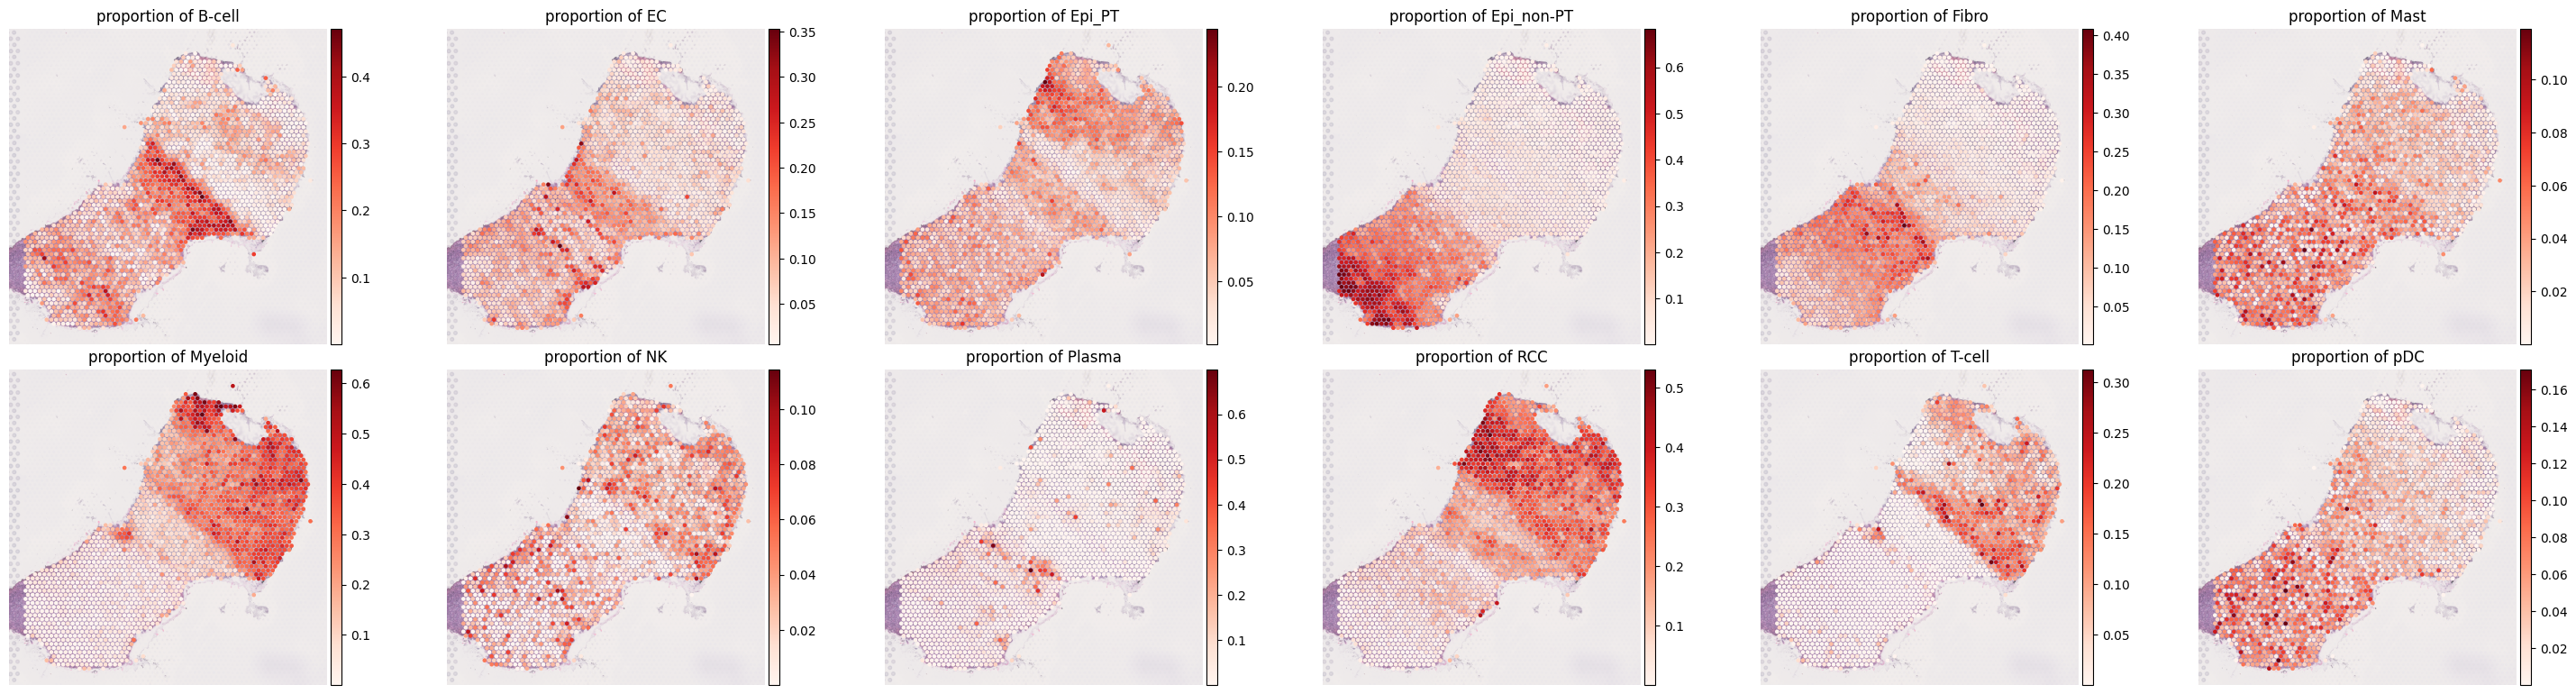

In [12]:
from MacSGP.vis import plot_spatial_ct

plot_spatial_ct(adata_st, index='proportion',
                proportion_threshold=0.0, num_threshold=100, 
                cmap='Reds', 
                spot_size=100, 
                ncols=6)